### Условие задачи


**Дано:**
- движение невесомого тела в системе из двух массивных тел, вращающихся относительно общего центра масс, описывается системой уравнений:

$\begin{cases}
\ddot{x} - 2\dot{y} = \frac{\partial{U}}{\partial{x}} \\
\ddot{y} + 2\dot{x} = \frac{\partial{U}}{\partial{y}} \\
\ddot{z} = \frac{\partial{U}}{\partial{z}} \\
U = \frac{1}{2} (x^2 + y^2) + \frac{\mu_1}{r_1} + \frac{\mu_2}{r_2} \\
r^2_1 = (x + \mu_2)^2 + y^2 + z^2 \\
r^2_2 = (x - \mu_1)^2 + y^2 + z^2
\end{cases}$

- константы модели для системы Солнце-Земля:
    - $\mu_2 = 3.001348389698916e-06$

- методы Рунге-Кутты для интегрирования систем ОДУ первого порядка, рассмотренные на семинарах
- алгоритм вычисления начальной скорости для неустойчивой орбиты вокруг L1, рассмотренный на семинаре
- библиотека математических алгоритмов [Tracker Component Library](https://github.com/USNavalResearchLaboratory/TrackerComponentLibrary/blob/master/Mathematical_Functions/Differential_Equations/RungeKStep.m)
- модули `numba`, `numpy`, `matplotlib`


**Требуется:**
1. Реализовать обобщенный метод Рунге-Кутты на основе таблицы Бутчера для интегрирования систем ОДУ первого порядка

    - функция для расчета одного шага размера $h$
    - функция для расчета $n$ шагов размера $h$ (1)
    - подготовить таблицу Бутчера для интегратора 5 порядка (см. Tracker Component Library)


2. Реализовать алгоритм вычисления начальной скорости для неустойчивой орбиты вокруг L1:

    - модификация функции (1) для досрочной остановки интегрирования при условии пересечения одной из плоскостей
    - функция для расчета начальной скорости $vy_0$ на основе метода бисекции для орбиты, заданной начальным положением $(x_0, 0, z_0)$ и условием ортогональности вектора скорости и плоскости $XOZ$ в начальный момент времени
    
        - $d_p = 1.4$ млн. км.
        - $x_{left} = x_{L1} - d_p$ - координата левой плоскости, заданной уравнением $x = x_{left}$
        - $x_{right} = x_{L1} + d_p$ - координата правой плоскости, заданной уравнением $x = x_{right}$


3. Реализовать алгоритм вычисления начальных скоростей орбит, начальные состояния которых заданы на решетке:
    - $(x_0, z_0) \in [x_{min}, x_{max}] \times [z_{min}, z_{max}]$

        - $d_g = 1.0$ млн. км.
        - $x_{min} = x_{L1} - d_g / 2$
        - $x_{max} = x_{L1} + d_g / 2$
        - $z_{min} = 0.0$
        - $z_{max} = d_g$

    - количество узлов на решетке $N \times N$


4. Использовать `@njit`, `@cfunc`, `prange` из модуля `numba` для компиляции всех функций и распараллеливания функции расчета на решетке


5. Вычислить начальные скорости и константы Якоби на заданных решетках
    - $J = 2 U - v^2$ - формула для вычисления константы Якоби
    - $h = 0.01721420632103996$ - шаг по времени `t`, равен 1 суткам в безразмерных единицах
    - $x_{L1}$ - координата точки L1 (см. материалы семинара)
    - $R = 149.6$ млн. км. - среднее расстояние Солнце-Земля
    - $[-0.1, 0.1]$ - начальный отрезок для уточнения скоростей методом бисекции


6. Измерить время вычислений


7. Сохранить результаты вычислений в файлах `*.npy` (функцией `np.save`)


8. Построить цветовые карты рассчитанных величин:

    - засечки по осям должны соответствовать координатам $x, z$, где $x$ отсчитывается относительно $x_{L1}$
    - единицы измерений по осям - километры
    - оси должны быть подписаны
    - должен присутствовать `colorbar`
    - должен присутствовать заголовок рисунка


9. Задокументировать все реализованные функции


**Материалы:**
- [Методы Рунге-Кутты](https://ru.wikipedia.org/wiki/Метод_Рунге_—_Кутты)
- [Динамика Солнечной Системы](https://disk.yandex.ru/i/HfJaUW2Sm62td)
- [Tracker Component Library](https://github.com/USNavalResearchLaboratory/TrackerComponentLibrary/blob/master/Mathematical_Functions/Differential_Equations/RungeKStep.m)
- [Mapping of initial conditions for libration point orbits](https://www.dropbox.com/s/wafy1jaylclngbv/Aksenov_ASR.pdf?dl=0)

In [2]:
import numpy as np
from scipy.optimize import bisect
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from numba import jit, njit, cfunc, prange
from npy_append_array import NpyAppendArray
import os
import time

In [4]:
@njit(cache=True, boundscheck=False)
def general_RungeKutta(right_part, timings, initial_state, step, model_constants, butcher_tableau, b, c):
    """
    One step in Runge-Kutta method.
    
    Parameters
    ----------
    right_part: array_like.
    Right part of differential equation.
    
    timings: float.
    Current time.
    
    initial_state: array_like.
    State vector.
    
    step: float.
    Time step.
        
    model_constants: array_like.
    Model parameters.
        
    butcher_tableau: array_like.
    A given Butcher's tableau.
    
    b: array_like.
    b-row of Butcher's table.
    
    c: array_like.
    c-column of Butcher's table.
    
    Returns
    -------
    : array_like.
    Update after iteration in a state of a system of differential equations.
    """
    degree = butcher_tableau.shape[1]
    matrix = np.zeros((degree, 6))
    for i in prange(1, degree+1):
        coefficients = np.zeros(6)
        if i > 1:
            for j in range(i-1):
                coefficients += butcher_tableau[i-1][j]*step*matrix[j]
        matrix[i-1] = right_part(timings + c[i-1]*step, initial_state + coefficients, model_constants)
    
    res = np.zeros(6)
    for i in range(degree):
        res += b[i]*matrix[i]
    return initial_state + res*step

/home/artem/.local/lib/python3.10/site-packages/numba/core/decorators.py:255: RuntimeWarning: forceobj is set for njit and is ignored
  warnings.warn('forceobj is set for njit and is ignored', RuntimeWarning)


In [5]:
@njit(cache=True, forceobj=True, boundscheck=False)
def general_RungeKutta_nsteps(right_part, timings, initial_state, step, model_constants, steps_number, butcher_tableau, b, c):
    """
    Performs several steps of Runge-Kutta method.
    
    Parameters
    ----------
    right_part: array_like.
    Right part of differential equation.
    
    timings: float.
    Current time.
    
    initial_state: array_like.
    State vector.
    
    step: float.
    Time step.
        
    model_constants: array_like.
    Model parameters.
        
    steps_number: int.
    A number of steps to perform.
        
    butcher_tableau: array_like.
    A given Butcher's tableau.
    
    b: array_like.
    b-row of Butcher's table.
    
    c: array_like.
    c-column of Butcher's table.
    
    Returns
    -------
    updated_state: array_like.
    Update after iteration in a state of a system of differential equations
    """
    updated_state = np.zeros((steps_number + 1, initial_state.shape[0] + 1))
    updated_state[:, 0] = timings*step + np.arange(steps_number + 1)
    updated_state[0, 1:] = initial_state
    
    for iteration in range(steps_number):
        updated_state[iteration + 1, 1:] = general_RungeKutta(right_part, updated_state[iteration][0], updated_state[iteration, 1:], 
                                                              step, model_constants, butcher_tableau, b, c)
        
    return updated_state

In [6]:
@njit(cache=True, parallel=True, forceobj=True, boundscheck=False)
def crtbp_ode(t, s, mc):
    """
    Circular Restricted Three Body Promlem ODE's right part.
    
    Parameters
    ----------
    t: float.
    Current time.
    
    s: array_like.
    State vector.
        
    mc: array_like.
    Model parameters.
    
    Returns
    -------
    : array_like.
    Right part of of differential equation. 
    """
    x, y, z, velocity_x, velocity_y, velocity_z = s
    mu2 = 3.001348389698916e-06
    mu1 = 1. - mu2

    r1 = ((x + mu2)**2 + y**2 + z**2)**1.5
    r2 = ((x - mu1)**2 + y**2 + z**2)**1.5

    acceleration_x = 2*velocity_y + x - (mu1 * (x + mu2)/r1 + mu2 * (x - mu1)/r2)
    constant = (mu1 / r1 + mu2 / r2)
    acceleration_y = -2*velocity_x + y - constant*y
    acceleration_z = -constant*z

    return np.array([velocity_x, velocity_y, velocity_z, acceleration_x, acceleration_y, acceleration_z])

In [7]:
@njit(cache=True, forceobj=True, boundscheck=False)
def general_RungeKutta_nsteps_planes(right_part, timings, initial_state, step, model_constants, n, planes):
    """
    Performs several steps of Runge-Kutta method with accounting the borders of plane to count in.
    
    Parameters
    ----------
    right_part: array_like.
    Right part of differential equation
    
    timings: float.
    Current time.
    
    initial_state: array_like.
    State vector.
    
    step: float.
    Time step.
        
    model_constants: array_like.
    Model parameters.
        
    n: int.
    Similar to steps_number: a number of steps to perform.
    
    planes: array_like.
    Borders that separate the space to count in.
    
    Returns
    -------
    : array_like.
    Updated array of system state after several iterations.
    """
    arr = np.empty((n + 1, initial_state.shape[0] + 1))
    arr[:, 0] = timings + step * np.arange(n + 1)
    arr[0, 1:] = initial_state

    i = 0
    for i in range(n):
        arr[i + 1, 1:] = general_RungeKutta(right_part = right_part, 
                                            timings = arr[i, 0],
                                            initial_state = arr[i, 1:], 
                                            step = step,
                                            model_constants = model_constants,
                                            butcher_tableau = butcher_tableau,
                                            b = b,
                                            c = c) 
        x = arr[i + 1, 1]
        if x < planes[0] or x > planes[1]:
            break

    return arr[:i + 2]

In [8]:
def v_star(s0, h, mc, n, A, b, c, pl):
    """
    Finds initial value of speed.
    
    Parameters
    ----------
    s0: array_like.
    Initial state of a system.
    
    h: float.
    Time step.
        
    mc: array_like.
    Model parameters.
        
    n: int.
    Number of iterations to perform.
        
    A: array_like.
    A given Butcher's tableau.
    
    b: array_like.
    b-row of Butcher's table.
    
    c: array_like.
    c-column of Butcher's table.
        
    pl: array_like.
    Borders that separate the space to count in.
    
    Returns
    -------
    : float.
    Result of calculations of speed.    
    """
    return bisect(get_plane, -0.1, 0.1, args=(crtbp_ode, s0, h, mc, n, A, b, c, pl), xtol=1e-12)

@njit(boundscheck=False)
def get_plane(vy, right_part, initial_state, step, model_constants, n, butcher_tableau, b, c, plane):
    """
    Custom function for futher optimization by scipy.bisect.
    
    Parameters
    ----------
    vy: float.
    y part of initial speed.
    
    right_part: array_like.
    Right part of differential equation.
    
    initial_state: array_like.
    State vector.
    
    step: float.
    Time step.
        
    model_constants: array_like.
    Model parameters.
        
    n: int.
    Similar to steps_number: a number of steps to perform.
        
    butcher_tableau: array_like.
    A given Butcher's tableau.
    
    b: array_like.
    b-row of Butcher's table.
    
    c: array_like.
    c-column of Butcher's table.
    
    plane: array_like.
    Border that separates the space to count in.
    
    Returns
    -------
    : int
    Part of graphic where everything happens.
    """
    s0 = initial_state.copy()
    s0[4] = vy
    res = general_RungeKutta_nsteps_planes(crtbp_ode, 0, s0, step, model_constants, n, plane)
    return -1 if res[-1][1] < np.mean(plane) else 1

@njit(cache=True, boundscheck=False)
def U(x,y,z):
    """
    A function to calculate U
    
    Parameters
    ----------
    x, y, z: float.
    A coordinate to count in
    
    Returns
    -------
    : float.
    A calculated pseudo-potential U
    """
    r1 = ((x + mu2)**2 + y**2 + z**2)**0.5
    r2 = ((x - mu1)**2 + y**2 + z**2)**0.5
    return 0.5*(x**2 + y**2) + mu1/r1 + mu2/r2

@jit(forceobj=True, boundscheck=False)
def calculations(jacobian, file):
    """
    A function that performs all the calculations.
    
    Parameters
    ----------
    
    jacobian: array_like.
    An array with Jacobi's constants.
    
    file: file.
    A killing-feature which allows to write to a file partly. Works like an array.
    """
    initial_state = np.zeros(6)
    for x_index in range(len(x_grid)):
        for z_index in range(len(z_grid)):
            initial_state[[0, 2]] = x_grid[x_index], z_grid[z_index]
            v_str = v_star(initial_state, step, model_constants, n, butcher_tableau, b, c, plane)
            initial_state[[0, 2, 4]] = x_grid[x_index], z_grid[z_index], v_str
            jacobian[x_index][z_index] = 2*U(x_grid[x_index], z_grid[z_index], 0) - v_str**2
            file.append(general_RungeKutta_nsteps_planes(crtbp_ode, 0, initial_state, step, model_constants, 
                                                    n, plane))

def partial_saving(N):
    """
    A function which saves partly all calculations. Created just to cope with memory problem.
    
    Parameters
    ----------
    N: int.
    A number of trajectories to count.
    
    Returns
    -------
    jacobian: array_like.
    An array with calculated Jacobi's constants.
    """
    os.system(f'rm orbits_{N}.npy')
    time_start = time.time()
    with NpyAppendArray(f'/home/artem/Programming Python/Unstable_orbit_dir/orbits_{N}.npy') as fuck:
        jacobian = np.zeros((N,N))
        calculations(jacobian, fuck)
    print(f'{N} trajectories\'re done in {(time.time() - time_start):.3f} seconds')
    return jacobian

## Butcher's Fifth-Order Runge-Kutta

$\begin{cases}
\vec{k}_1 = \vec{f}(t_n, \vec{s}_n) \\
\vec{k}_2 = \vec{f}(t_n + \frac{h}{4}, \vec{s}_n + \frac{h}{4}\vec{k}_1) \\
\vec{k}_3 = \vec{f}(t_n + \frac{h}{4}, \vec{s}_n + \frac{h}{8}\vec{k}_1 + \frac{h}{8}\vec{k}_2) \\
\vec{k}_4 = \vec{f}(t_n + \frac{h}{2}, \vec{s}_n - \frac{h}{2}\vec{k}_2 + \vec{k}_3h) \\
\vec{k}_5 = \vec{f}(t_n + \frac{3h}{4}, \vec{s}_n + \frac{3}{16}\vec{k}_1h + \frac{9}{16}\vec{k}_4h) \\
\vec{k}_6 = \vec{f}(t_n + h, \vec{s}_n - \frac{3}{7}\vec{k}_1h + \frac{2}{7}\vec{k}_2h + \frac{12}{7}\vec{k}_3h - \frac{12}{7}\vec{k}_4h + \frac{8}{7}\vec{k}_5h) \\
\vec{s}_{n+1} = \vec{s}_n + \frac{h}{90}(7\vec k_1 + 32\vec k_3 + 12\vec k_4 + 32\vec k_5 + 7\vec k_6)
\end{cases}
$

Взято из `"Numerical Methods for Engineers, 6th edition" Steven Chapra, Raymond Canale`

In [9]:
c = np.array([0, 1/4, 1/4, 1/2, 3/4, 1])
b = np.array([7/90, 0, 32/90, 12/90, 32/90, 7/90])

butcher_tableau = np.array([[0, 0, 0, 0, 0, 0],  #k1
                          [1/4, 0, 0, 0, 0, 0],  #k2
                          [1/8, 1/8, 0, 0, 0, 0],  #k3
                          [0, -1/2, 1, 0, 0, 0],  #k4
                          [3/16, 0, 0, 9/16, 0, 0],  #k5
                          [-3/7, 2/7, 12/7, -12/7, 8/7, 0]]) 

R = 149600000 
d_p = 1400000 / R
mu2 = 3.001348389698916e-06
mu1 = (1 - mu2)
xL1 = 0.9900289479871318
d = (mu1 - xL1) * 0.99
step = 0.01721420632103996
model_constants = np.array([mu2])
xmin = xL1 - d_p
xmax = xL1 + d_p
plane = np.array([xmin, xmax])

np.set_printoptions(precision=3)
butcher_tableau

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.25 ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.125,  0.125,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.5  ,  1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.188,  0.   ,  0.   ,  0.562,  0.   ,  0.   ],
       [-0.429,  0.286,  1.714, -1.714,  1.143,  0.   ]])

In [10]:
for N in [40, 80, 160, 320, 640]:
    n = 10000
    h = 1000000 / R
    
    x_min, x_max = xL1 - h/2, xL1 + h/2
    z_min, z_max = 0, h

    x_grid = np.linspace(x_min, x_max, N)
    z_grid = np.linspace(z_min, z_max, N)
    J = partial_saving(N)
    np.save(f'{N}_orbits_jacobi.npy', J)

40 trajectories're done in 59.894 seconds
80 trajectories're done in 212.656 seconds


rm: невозможно удалить 'orbits_160.npy': Нет такого файла или каталога


160 trajectories're done in 853.727 seconds


rm: невозможно удалить 'orbits_320.npy': Нет такого файла или каталога


320 trajectories're done in 3412.266 seconds


rm: невозможно удалить 'orbits_640.npy': Нет такого файла или каталога


640 trajectories're done in 13637.735 seconds


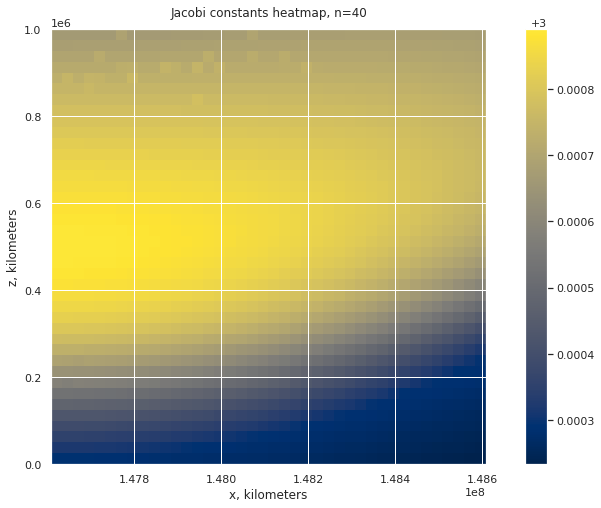

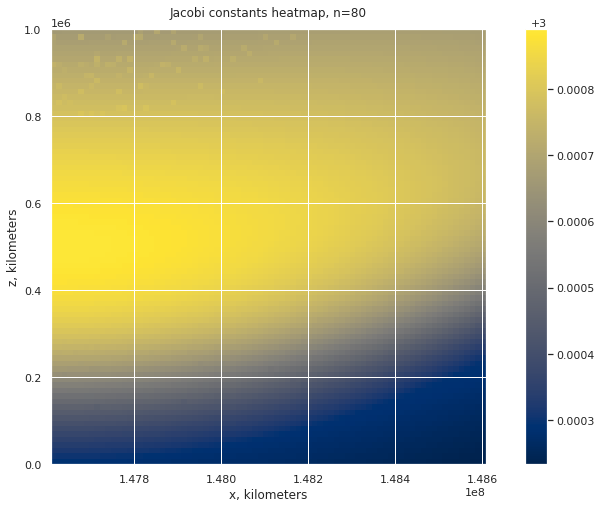

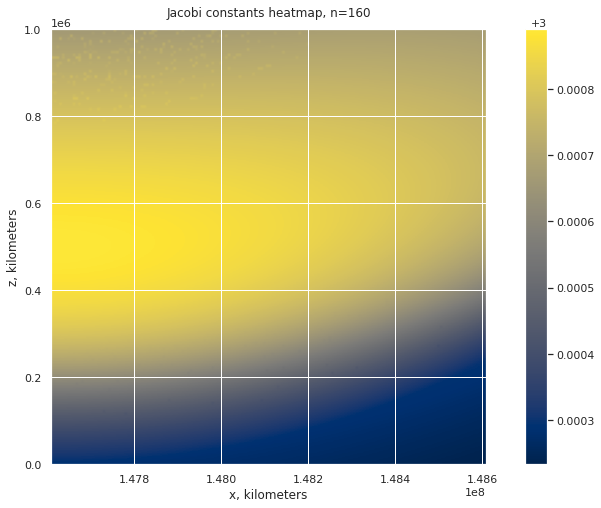

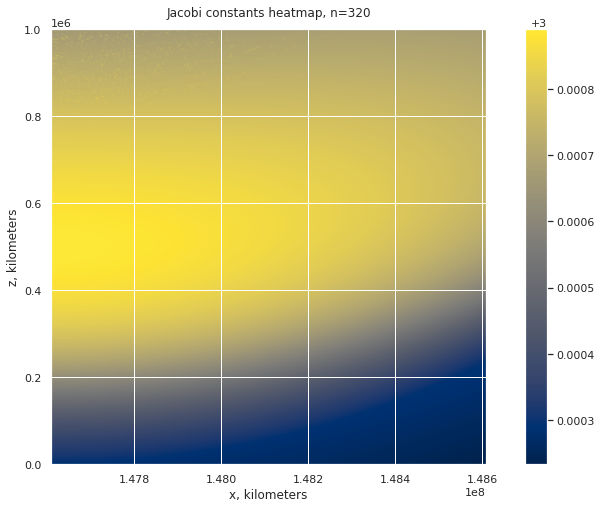

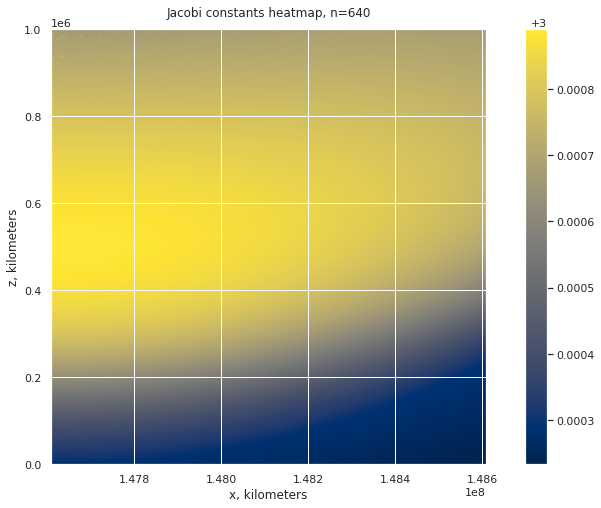

In [71]:
R = 149600000 
xL1 = 0.9900289479871318
h = 1000000 / R

x_min, x_max = xL1 - h/2, xL1 + h/2
z_min, z_max = 0, h

for N in [40, 80, 160, 320, 640]:
    J = np.load(f'{N}_orbits_jacobi.npy', mmap_mode='r')
    plt.figure(figsize=(14, 8))
    plt.imshow(J.reshape(N, N), cmap='cividis', origin='lower', extent=[x_min * R, x_max * R, z_min * R, z_max * R])
    plt.colorbar()
    plt.xlabel('x, kilometers')
    plt.ylabel('z, kilometers')
    plt.title(f"Jacobi constants heatmap, n={N}", pad=13)
    plt.show()